In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from Bio import SeqIO
import numpy as np

df = pd.read_csv(r"/home/natant/Thesis-plmbind/Data/TF_database/DatabaseExtract_v_1.01.csv")

In [4]:
DB_TF_only = df[df["Is TF?"]=="Yes"]["HGNC symbol"].to_list()
DB_all = df["HGNC symbol"].to_list()
TF_list = []
with open('/home/natant/Thesis-plmbind/Thesis/utils/TF_split/TF_data_split/ALL_TFs.txt') as f:
    for TF in f:
        TF_list.append(TF.strip())

In [6]:
filtered_TF_list = [TF for TF in TF_list if TF in DB_TF_only]

In [15]:
seqs_path = "/home/natant/Thesis-plmbind/Thesis/utils/data_processing/TF_sequences.fasta"
sequences = {fasta.id:str(fasta.seq) for fasta in SeqIO.parse(open(seqs_path),'fasta')}
filtered_TF_list_with_seq = [TF for TF in filtered_TF_list if sequences[TF] != "0"]

In [16]:
print("TFs in ChIP dataset: " + str(len(TF_list)))
print("Amount found in TF database: "+str(len([TF for TF in TF_list if TF in DB_all])))
print("Amount identified as TF by database: "+str(len(filtered_TF_list)))
print("With sequence: "+str(len(filtered_TF_list_with_seq)))


TFs in ChIP dataset: 1210
Amount found in TF database: 1032
Amount identified as TF by database: 855
With sequence: 851


In [18]:
df_filtered = df[[TF2 in filtered_TF_list_with_seq for TF2 in df["HGNC symbol"].to_list()]]

In [19]:
DBD_count = pd.DataFrame(df_filtered["DBD"].value_counts())
DBD_count.columns = ["ChIP_count"]
DBD_count['DBD_name'] = DBD_count.index
DBD_count_DB = pd.DataFrame(df[df["Is TF?"]=="Yes"]["DBD"].value_counts())
DBD_count_DB.columns = ["DB_count"]
DBD_count_DB['DBD_name'] = DBD_count_DB.index
DBD_count = pd.merge(DBD_count_DB, DBD_count, on = "DBD_name", how="outer").fillna(0)
DBD_count.index = DBD_count["DBD_name"]
DBD_count

,DB_count,DBD_name,ChIP_count
DBD_name,,,
C2H2 ZF,747,C2H2 ZF,467.0
Homeodomain,196,Homeodomain,46.0
bHLH,108,bHLH,48.0
Unknown,69,Unknown,23.0
bZIP,54,bZIP,38.0
...,...,...,...
FLYWCH,1,FLYWCH,0.0
Brinker,1,Brinker,0.0
TCR/CxC,1,TCR/CxC,1.0


In [20]:
DBD_count_rearranged = DBD_count.drop("Unknown")
DBD_count_rearranged = DBD_count_rearranged.append(DBD_count.loc[DBD_count['DBD_name'] == "Unknown"],ignore_index=True)
print(DBD_count_rearranged)

    DB_count          DBD_name  ChIP_count
0        747           C2H2 ZF       467.0
1        196       Homeodomain        46.0
2        108              bHLH        48.0
3         54              bZIP        38.0
4         49          Forkhead        16.0
..       ...               ...         ...
60         1           Brinker         0.0
61         1           TCR/CxC         1.0
62         1      Ets; AT hook         1.0
63         1  ARID/BRIGHT; RFX         1.0
64        69           Unknown        23.0

[65 rows x 3 columns]


/tmp/ipykernel_14539/58919882.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DBD_count_rearranged = DBD_count_rearranged.append(DBD_count.loc[DBD_count['DBD_name'] == "Unknown"],ignore_index=True)


In [21]:
TF_amount = 9
DBD_count_largest = DBD_count[0:TF_amount]
DBD_count_largest = DBD_count_largest.append(DBD_count[TF_amount:].sum(), ignore_index=True)
DBD_count_largest.iloc[-1, DBD_count_largest.columns.get_loc("DBD_name")] = "Others"
idx = DBD_count_largest.index.tolist()
unknown_pos = DBD_count_largest.index[DBD_count_largest['DBD_name']=="Unknown"].tolist()
idx.pop(unknown_pos[0])
idx.insert(-1, unknown_pos[0])
DBD_count_largest = DBD_count_largest.reindex(idx)
DBD_count_smallest = DBD_count[TF_amount:]

/tmp/ipykernel_14539/1967652514.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DBD_count_largest = DBD_count_largest.append(DBD_count[TF_amount:].sum(), ignore_index=True)


In [22]:
DBD_count_largest

,DB_count,DBD_name,ChIP_count
0,747,C2H2 ZF,467.0
1,196,Homeodomain,46.0
2,108,bHLH,48.0
4,54,bZIP,38.0
5,49,Forkhead,16.0
6,46,Nuclear receptor,29.0
7,30,HMG/Sox,15.0
8,27,Ets,19.0
3,69,Unknown,23.0
9,313,Others,150.0


In [23]:
temp_count = DBD_count_largest["DB_count"].to_list() + DBD_count_largest["ChIP_count"].to_list()
temp_names = DBD_count_largest["DBD_name"].to_list()*2
temp_indentity = (TF_amount+1)*["DB"] + (TF_amount+1)*["ChIP"]
DBD_count_largest_plot = pd.DataFrame({"Name": temp_names, "Count": temp_count, "Iden": temp_indentity})

temp_count = DBD_count_smallest["DB_count"].to_list() + DBD_count_smallest["ChIP_count"].to_list()
temp_names = DBD_count_smallest["DBD_name"].to_list()*2
temp_indentity = len(DBD_count_smallest["ChIP_count"].to_list())*["DB"] + len(DBD_count_smallest["ChIP_count"].to_list())*["ChIP"]
DBD_count_smallest_plot = pd.DataFrame({"Name": temp_names, "Count": temp_count, "Iden": temp_indentity})

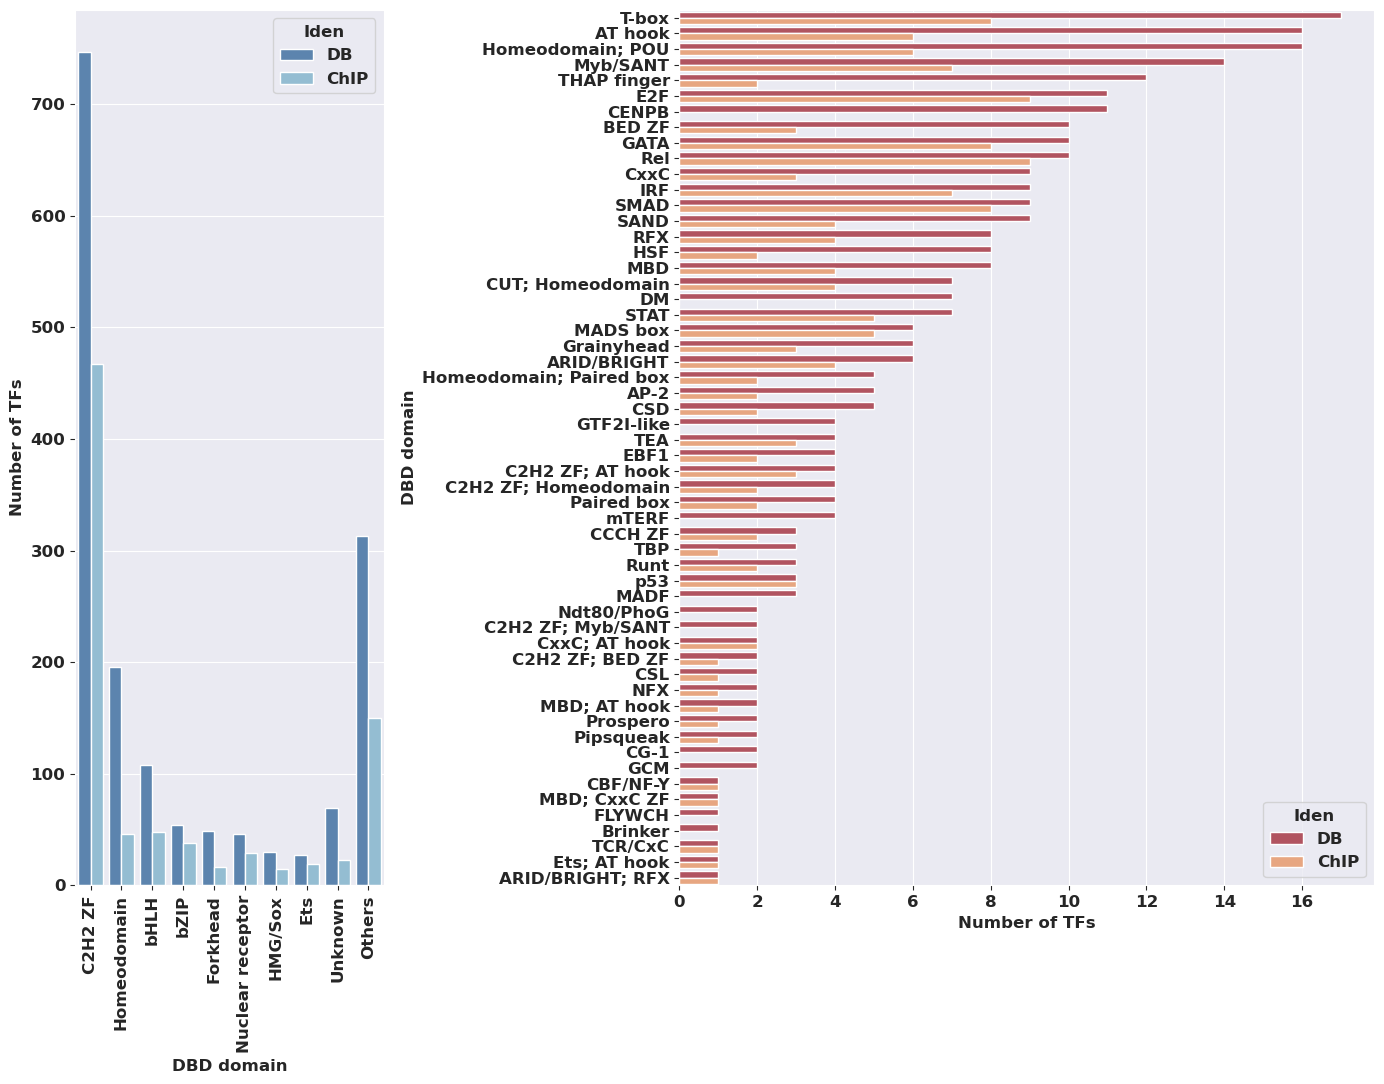

In [25]:
sns.set_style("darkgrid", {'xtick.bottom': True, 'ytick.left': True})
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}
# matplotlib.rcParams.update({'font.size': 12})
# matplotlib.rcParams.update({'font.weight': "bold"})
# matplotlib.rcParams.update({'axes.size': 12})
# matplotlib.rcParams.update({'axes.weight': "bold"})
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1,2,gridspec_kw={'width_ratios': [4, 9]},figsize=(14,11))
sns.barplot(ax = ax[0], data = DBD_count_largest_plot, x = "Name", y = "Count", hue="Iden", palette=['#4e84bc', '#8ac0dc'])
ax[0].set_xlabel('DBD domain', **font)
ax[0].set_ylabel('Number of TFs', **font)
ax[0].tick_params(axis='x', rotation=90)
sns.barplot(ax = ax[1], data = DBD_count_smallest_plot, y = "Name", x = "Count",hue="Iden", palette=["#c14454", "#f8a270"])
ax[1].set_ylabel('DBD domain', **font)
ax[1].set_xlabel('Number of TFs', **font)
plt.tight_layout()
plt.savefig("Dataset_vs_actual.png")


In [26]:
df_filtered
families_count = pd.DataFrame(df_filtered["DBD"].value_counts())
motif_count = pd.DataFrame(df_filtered["TF assessment"].value_counts())
motif_count

,TF assessment
Known motif,683
Likely to be sequence specific TF,144
Inferred motif,24


In [27]:
all_TF_DF = pd.read_pickle("/home/natan/Documents/Thesis/project-main/Thesis-Protein-Ligand/TF_data_split/all_TF_DF.pkl")
all_celltypes = pd.read_pickle("/home/natan/Documents/Thesis/project-main/Thesis-Protein-Ligand/TF_data_split/all_celltypes.pkl")

FileNotFoundError: [Errno 2] No such file or directory: '/home/natan/Documents/Thesis/project-main/Thesis-Protein-Ligand/TF_data_split/all_TF_DF.pkl'

In [15]:
all_celltypes

,ZNF671,NKX2-1,KLF14,KAT8,XRN2,SATB1,POU3F2,HNRNPUL1,ISL2,LEF1,...,CDC5L,ZNF333,KDM4A,NUTM1,ZNF3,ZFP82,SMARCA4,TRIM25,TBL1X,ZNF843
0,,,,,,,,,,,,,,,,,,,,,
HEK293T,3279.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,288.0,...,NaN,1228.0,NaN,NaN,NaN,NaN,NaN,NaN,43681.0,NaN
NCI-H3122,NaN,61517.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H9,NaN,53416.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NCI-H2087,NaN,13458.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NCI-H1819,NaN,11235.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCI-H1975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
embryonic-kidney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,45410.0,NaN,NaN,NaN,NaN,NaN,NaN
NUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,20216.0,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Generate number of celltypes per TF
celltypes_per_TF = pd.DataFrame({"Count":(all_celltypes>0).sum().sort_values(ascending=False)})
# celltypes_per_TF_dist = pd.DataFrame(pd.cut(celltypes_per_TF["Count"], bins=[0,1,2,3,4,5,10,20,30,40,50,100,200,300]).value_counts(sort=False))
# sns.set_style("darkgrid")
# fig, ax = plt.subplots(figsize=(7,3))
# sns.barplot(ax = ax, data=celltypes_per_TF_dist, x=celltypes_per_TF_dist.index, y="Count")
# ax.bar_label(ax.containers[0])
# plt.title("Number of celltypes per TF")
# plt.xticks(rotation = 90)
# plt.xlabel("Bins")

In [17]:
celltypes_per_TF = celltypes_per_TF.reset_index()

Text(0.5, 0, 'Bins')

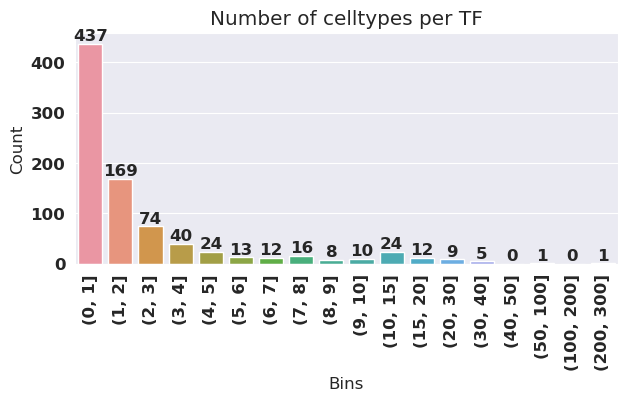

In [22]:
celltypes_per_TF_filtered = celltypes_per_TF[[i in filtered_TF_list for i in celltypes_per_TF["index"]]]
celltypes_per_TF_filtered
celltypes_per_TF_filtered_dist = pd.DataFrame(pd.cut(celltypes_per_TF_filtered["Count"], bins=[0,1,2,3,4,5,6,7,8,9,10,15,20,30,40,50,100,200,300]).value_counts(sort=False))
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(7,3))
sns.barplot(ax = ax, data=celltypes_per_TF_filtered_dist, x=celltypes_per_TF_filtered_dist.index, y="Count")
ax.bar_label(ax.containers[0])
plt.title("Number of celltypes per TF")
plt.xticks(rotation = 90)
plt.xlabel("Bins")

In [23]:
celltypes_per_TF_filtered

,index,Count
0,CTCF,210
3,MYC,51
4,STAT3,38
5,RELA,36
6,FOXA1,34
...,...,...
1205,ZXDC,1
1206,ZNF362,1
1207,ZNF605,1
1208,FEZF1,1


In [37]:
# Sanity check!!! 
df_filtered.sort_values(by=["HGNC symbol"])["HGNC symbol"].to_list() == celltypes_per_TF_filtered.sort_values(by=["index"])["index"].to_list()
df_filtered = df_filtered.sort_values(by=["HGNC symbol"])
df_filtered["Types"] = celltypes_per_TF_filtered.sort_values(by=["index"])["Count"].to_list()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53]),
 [Text(0, 0, 'Homeodomain'),
  Text(1, 0, 'C2H2 ZF'),
  Text(2, 0, 'bHLH'),
  Text(3, 0, 'Nuclear receptor'),
  Text(4, 0, 'Unknown'),
  Text(5, 0, 'ARID/BRIGHT; RFX'),
  Text(6, 0, 'ARID/BRIGHT'),
  Text(7, 0, 'AT hook'),
  Text(8, 0, 'bZIP'),
  Text(9, 0, 'Myb/SANT'),
  Text(10, 0, 'CUT; Homeodomain'),
  Text(11, 0, 'CxxC'),
  Text(12, 0, 'SAND'),
  Text(13, 0, 'E2F'),
  Text(14, 0, 'EBF1'),
  Text(15, 0, 'Ets'),
  Text(16, 0, 'Ets; AT hook'),
  Text(17, 0, 'T-box'),
  Text(18, 0, 'Forkhead'),
  Text(19, 0, 'GATA'),
  Text(20, 0, 'Grainyhead'),
  Text(21, 0, 'HMG/Sox'),
  Text(22, 0, 'HSF'),
  Text(23, 0, 'IRF'),
  Text(24, 0, 'CxxC; AT hook'),
  Text(25, 0, 'Pipsqueak'),
  Text(26, 0, 'TCR/CxC'),
  Text(27, 0, 'MBD; CxxC ZF'),
  Text(28,

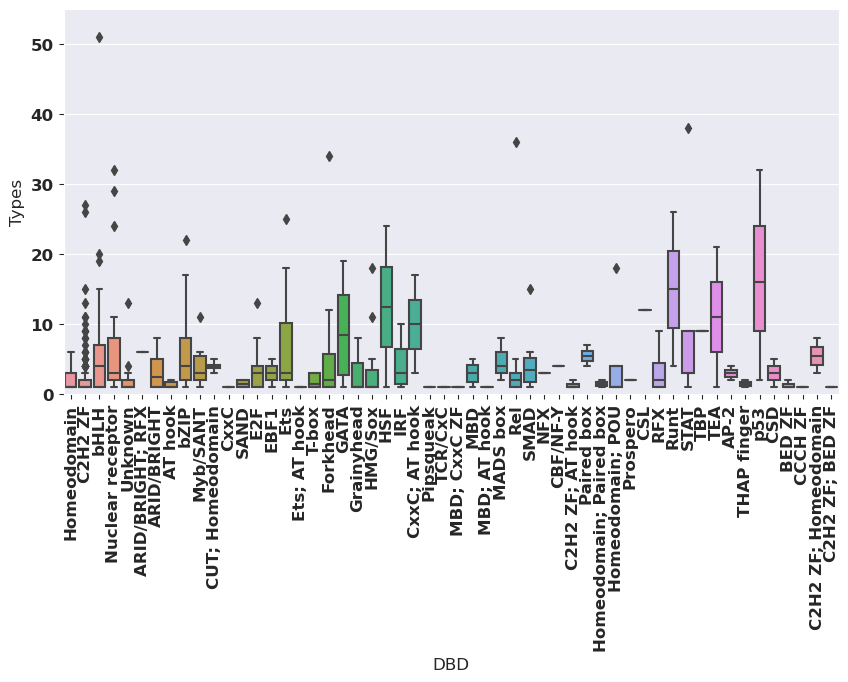

In [52]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(ax=ax, data=df_filtered, x="DBD", y="Types")
ax.set_ylim(0,55)
plt.xticks(rotation = 90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Homeodomain'),
  Text(1, 0, 'C2H2 ZF'),
  Text(2, 0, 'bHLH'),
  Text(3, 0, 'Nuclear receptor'),
  Text(4, 0, 'Unknown'),
  Text(5, 0, 'bZIP'),
  Text(6, 0, 'Ets'),
  Text(7, 0, 'Forkhead'),
  Text(8, 0, 'HMG/Sox')])

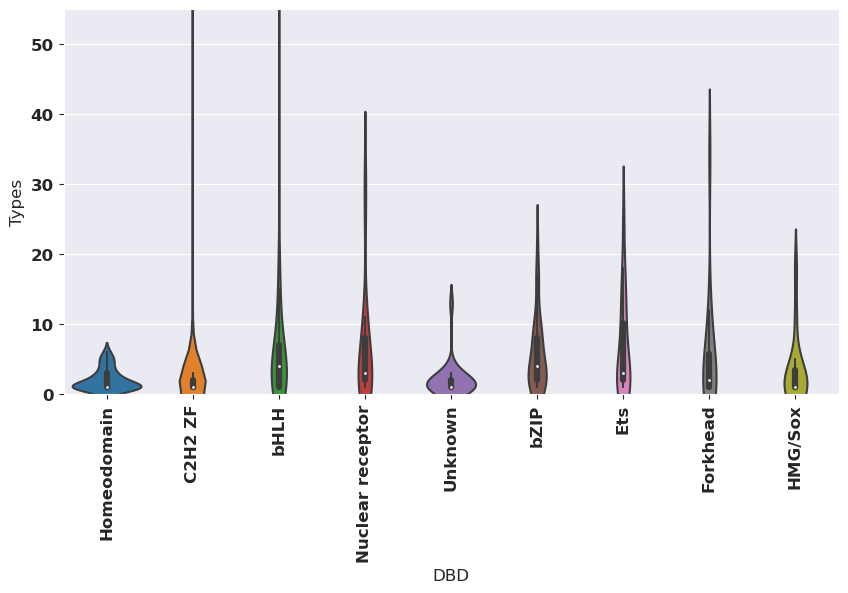

In [53]:
fig, ax = plt.subplots(figsize=(10,5))
sns.violinplot(ax=ax, data=df_filtered[[i in DBD_count_largest["DBD_name"].to_list() for i in df_filtered["DBD"]]], x="DBD", y="Types")
ax.set_ylim(0,55)
plt.xticks(rotation = 90)

In [47]:
DBD_count_largest["DBD_name"].to_list()

['C2H2 ZF',
 'Homeodomain',
 'bHLH',
 'bZIP',
 'Forkhead',
 'Nuclear receptor',
 'HMG/Sox',
 'Ets',
 'Unknown',
 'Others']

In [66]:
len(df_filtered[df_filtered["DBD"] == "C2H2 ZF"]["HGNC symbol"].to_list())

467

In [77]:
import random
all_ZNFs = df_filtered[df_filtered["DBD"] == "C2H2 ZF"]["HGNC symbol"].to_list()
random.shuffle(all_ZNFs)
ZNF_test = all_ZNFs[:50]
ZNF_val = all_ZNFs[50:100]
ZNF_train = all_ZNFs[100:]

import pickle
with open("ZNF_test", "wb") as f: # "wb" because we want to write in binary mode
    pickle.dump(ZNF_test, f)
with open("ZNF_val", "wb") as f: # "wb" because we want to write in binary mode
    pickle.dump(ZNF_val, f)
with open("ZNF_train", "wb") as f: # "wb" because we want to write in binary mode
    pickle.dump(ZNF_train, f)